# Predicting Housing Prices

<img src="houses.jpg" alt="Drawing" style="width: 1000px;"/>

In this project, I use different regression models to predict sale prices of homes. The data consists of 1460 home sales in Ames, Iowa between 2006 and 2010, and contains 81 attributes about these sales. The data was collected by Dean De Cock for the purposes of data science education. More information about the data set can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data), where it is also available for download. 

In [1]:
# import packages

import pandas as pd
import numpy as np
from scipy.stats import norm, skew

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
inline_rc = dict(mpl.rcParams)

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_validate, KFold, RepeatedKFold

import warnings


In [2]:
# read in the data and explore

df = pd.read_csv(r'house-prices-advanced-regression-techniques/train.csv')

print(df.head())
print(df.info())

str_col_df = df.copy().select_dtypes(include=['object'])
for col in str_col_df.columns:
    print('\n' + col)
    print(df[col].value_counts())


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

# Transform the data


### Initial cleaning

* Split off the ID column since we won't use it in feature selection
* Convert numerical categorical columns to strings
* Sanity check on the dates: Are they dates that can exist?
* Convert absolute year values to ages
* Add columns that may be more useful than the sum of their parts

In [3]:
trans_df = df.copy()

def initial_clean(trans_df):
    
    # separate the ID column
    id_col = trans_df[['Id']]
    trans_df.drop('Id', axis=1, inplace=True)

    # convert MS SubClass into string
    trans_df['MSSubClass'] = trans_df['MSSubClass'].astype(str)
    
    # sanity check - do the dates make sense?
    print('\n\033[1mSanity check on dates\033[0m')
    for col in ['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold']:
        print(col)
        tm_per = trans_df[col].unique()
        tm_per.sort()
        print(tm_per)
        
    # convert year into age
    trans_df['AgeAtSale'] = trans_df['YrSold'] - trans_df['YearBuilt']
    trans_df['YearsSinceRemodel'] = trans_df['YrSold'] - trans_df['YearRemodAdd']
    trans_df['GarageAge'] = trans_df['YrSold'] - trans_df['GarageYrBlt']
    trans_df.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

    # replace row with negative age with 0
    for col in ['AgeAtSale', 'YearsSinceRemodel', 'GarageAge']:
        trans_df.loc[trans_df[col] < 0, col] = 0
    
    # add num bathrooms and total sq ft
    trans_df['NumBath'] = trans_df['BsmtFullBath'] + 0.5 * trans_df['BsmtHalfBath'] + trans_df['FullBath'] + 0.5 * trans_df['HalfBath']
    trans_df['HouseSF'] = trans_df['1stFlrSF'] + trans_df['2ndFlrSF'] + trans_df['TotalBsmtSF']

#     # remove columns with data leakage
#     trans_df.drop(['MoSold', 'YrSold', 'SaleType', 'SaleCondition'], axis=1, inplace=True)

    return trans_df, id_col

trans_df, id_col = initial_clean(trans_df)




Sanity check on dates
YrSold
[2006 2007 2008 2009 2010]
YearBuilt
[1872 1875 1880 1882 1885 1890 1892 1893 1898 1900 1904 1905 1906 1908
 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923
 1924 1925 1926 1927 1928 1929 1930 1931 1932 1934 1935 1936 1937 1938
 1939 1940 1941 1942 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954
 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968
 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982
 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010]
YearRemodAdd
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010]
GarageYrBlt
[1900. 1906. 1908. 1910. 191

### Add binary "exists" columns

Add attributes showing simply whether something existed or not, rather than its quality or square footage. Drop the corresponding columns for these when they seem particularly unlikely to affect price.

In [4]:
def create_exists_feat(trans_df):

    trans_df.loc[pd.isnull(trans_df['BsmtQual']), 'BsmtExists'] = 0
    trans_df.loc[~pd.isnull(trans_df['BsmtQual']), 'BsmtExists'] = 1

    trans_df.loc[trans_df['2ndFlrSF'] == 0, '2ndFlrExists'] = 0
    trans_df.loc[trans_df['2ndFlrSF'] > 0, '2ndFlrExists'] = 1

    trans_df.loc[trans_df['WoodDeckSF'] + trans_df['OpenPorchSF'] + trans_df['EnclosedPorch'] + trans_df['3SsnPorch'] + trans_df['ScreenPorch'] == 0, 'PorchExists'] = 0
    trans_df.loc[trans_df['WoodDeckSF'] + trans_df['OpenPorchSF'] + trans_df['EnclosedPorch'] + trans_df['3SsnPorch'] + trans_df['ScreenPorch'] > 0, 'PorchExists'] = 1

    trans_df.loc[pd.isnull(trans_df['PoolQC']), 'PoolExists'] = 0
    trans_df.loc[~pd.isnull(trans_df['PoolQC']), 'PoolExists'] = 1
    for col in trans_df.columns:
        if 'Pool' in col and col != 'PoolExists':
            trans_df.drop(col, axis=1, inplace=True)

    trans_df.loc[pd.isnull(trans_df['Fence']), 'FenceExists'] = 0
    trans_df.loc[~pd.isnull(trans_df['Fence']), 'FenceExists'] = 1
    trans_df.drop('Fence', axis=1, inplace=True)
    
    trans_df.loc[trans_df['Fireplaces'] == 0, 'FireplaceExists'] = 0
    trans_df.loc[trans_df['Fireplaces'] > 0, 'FireplaceExists'] = 1
    for col in trans_df.columns:
        if 'Fireplace' in col and col != 'FireplaceExists':
            trans_df.drop(col, axis=1, inplace=True)

    trans_df.loc[pd.isnull(trans_df['Alley']), 'AlleyExists'] = 0
    trans_df.loc[~pd.isnull(trans_df['Alley']), 'AlleyExists'] = 1
    trans_df.drop('Alley', axis=1, inplace=True)

    trans_df.loc[trans_df['MiscFeature'] == 'Shed', 'ShedExists'] = 1
    trans_df.loc[trans_df['MiscFeature'] != 'Shed', 'ShedExists'] = 0
    for col in trans_df.columns:
        if 'Misc' in col:
            trans_df.drop(col, axis=1, inplace=True)
    
    print('\n\033[1mNew exists columns\033[0m')
    for col in ['BsmtExists', '2ndFlrExists', 'PorchExists', 'PoolExists', 'FenceExists', 'AlleyExists', 'ShedExists']:
        print(trans_df[col].value_counts())
    
    return trans_df

trans_df = create_exists_feat(trans_df)




New exists columns
1.0    1423
0.0      37
Name: BsmtExists, dtype: int64
0.0    829
1.0    631
Name: 2ndFlrExists, dtype: int64
1.0    1206
0.0     254
Name: PorchExists, dtype: int64
0.0    1453
1.0       7
Name: PoolExists, dtype: int64
0.0    1179
1.0     281
Name: FenceExists, dtype: int64
0.0    1369
1.0      91
Name: AlleyExists, dtype: int64
0.0    1411
1.0      49
Name: ShedExists, dtype: int64


### Handle missing values

* Replace NAs with category None where appropriate
* Fill in remaining columns NAs - 0s, or median or mode for the neighborhood


In [5]:
def handle_missing_values(trans_df):
    
    # replace NAs with None
    for col in ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
        # try/except to handle when these were removed in another step
        try:
            trans_df[col].fillna('None', inplace=True)
        except:
            pass

    # get remaining nulls
    print('\n\033[1mNull counts\033[0m')
    null_counts = trans_df.isnull().sum()[trans_df.isnull().sum() > 0]
    print(null_counts)
    
    for col in null_counts.index:
        print('\n')
        print(trans_df[col].value_counts())

    # replace null veneer types with 'None'
    trans_df['MasVnrType'].fillna('None', inplace=True)
    trans_df['MasVnrArea'].fillna(0, inplace=True)

    # replace blank lot frontage with the median for the neighborhood
    trans_df['LotFrontage'] = trans_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    # replace electrical with the mode for the neighborhood
    trans_df['Electrical'] = trans_df.groupby('Neighborhood')['Electrical'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # replace garage age with the median for the neighborhood
    trans_df['GarageAge'] = trans_df.groupby('Neighborhood')['GarageAge'].transform(lambda x: x.fillna(x.median()))
    
    return trans_df
    
    
trans_df = handle_missing_values(trans_df)




Null counts
LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
GarageAge       81
dtype: int64


60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
112.0      1
138.0      1
149.0      1
38.0       1
111.0      1
Name: LotFrontage, Length: 110, dtype: int64


None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64


0.0      861
108.0      8
72.0       8
180.0      8
16.0       7
        ... 
31.0       1
366.0      1
528.0      1
894.0      1
415.0      1
Name: MasVnrArea, Length: 327, dtype: int64


SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


1.0      87
0.0      84
4.0      45
2.0      35
5.0      34
         ..
96.0      1
94.0      1
76.0      1
99.0      1
107.0     1
Name: GarageAge, Length: 101, dtype: int64


### Map quality variables to ordinal values

Many of the columns in this dataset are qualitative (e.g. excellent vs good vs average vs poor) and can be translated to an ordinal scale.

In [6]:
def map_qual_to_ord(trans_df):

    street_dict = {'Pave': 1, 'Grvl': 0}
    trans_df['Street'] = trans_df['Street'].map(street_dict)

    util_dict = {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1}
    trans_df['Utilities'] = trans_df['Utilities'].map(util_dict)

    slope_dict = {'Gtl': 0, 'Mod': -1, 'Sev': -2}
    trans_df['LandSlope'] = trans_df['LandSlope'].map(slope_dict)

    bsmtexp_dict = {'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0, 'None': 0}
    trans_df['BsmtExposure'] = trans_df['BsmtExposure'].map(bsmtexp_dict)

    bsmtfin_dict = {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0, 'None': -1}
    trans_df['BsmtFinType1'] = trans_df['BsmtFinType1'].map(bsmtfin_dict)
    trans_df['BsmtFinType2'] = trans_df['BsmtFinType2'].map(bsmtfin_dict)

    air_dict = {'N': 0, 'Y': 1}
    trans_df['CentralAir'] = trans_df['CentralAir'].map(air_dict)

    elec_dict = {'SBrkr': 1, 'FuseA': 0, 'Mix': 0, 'FuseF': -1, 'FuseP': -2}
    trans_df['Electrical'] = trans_df['Electrical'].map(elec_dict)

    func_dict = {'Typ': 0, 'Min1': -1, 'Min2': -2, 'Mod': -3, 'Maj1': -4, 'Maj2': -5, 'Sev': -6, 'Sal': -7}
    trans_df['Functional'] = trans_df['Functional'].map(func_dict)

    grgfin_dict = {'Fin': 2, 'RFn': 1, 'Unf': 0, 'None': -1}
    trans_df['GarageFinish'] = trans_df['GarageFinish'].map(grgfin_dict)

    drive_dict = {'Y': 2, 'P': 1, 'N': 0}
    trans_df['PavedDrive'] = trans_df['PavedDrive'].map(drive_dict)
    
#     housestyle_dict = {'1Story': 0, '1.5Unf': 1, '1.5Fin': 2, 'SFoyer': 3,  'SLvl': 4, '2Story': 5, '2.5Unf': 6, '2.5Fin': 7}
#     trans_df['HouseStyle'] = trans_df['HouseStyle'].map(drive_dict)
    
    qual_dict = {'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2, 'None': -3}
    for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']:
        trans_df[col] = trans_df[col].map(qual_dict)
        
    return trans_df


trans_df = map_qual_to_ord(trans_df)



### Check for skew

Transform the variables that are not normally distributed.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


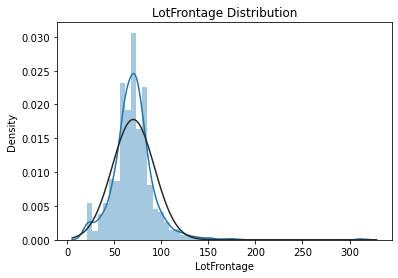

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


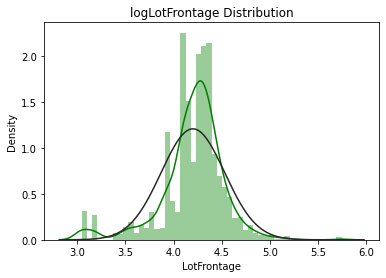

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


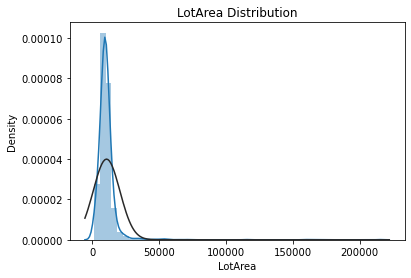

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


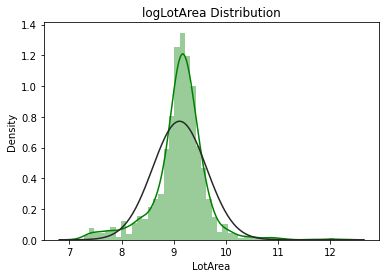

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


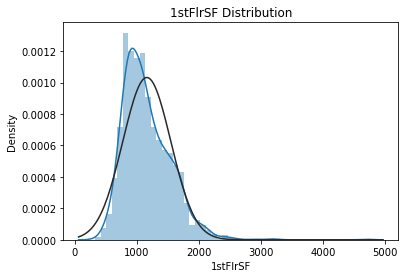

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


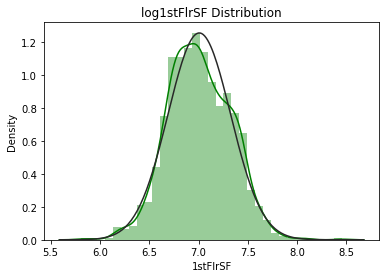

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


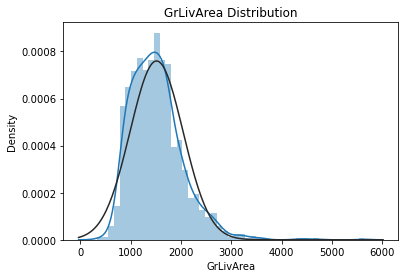

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


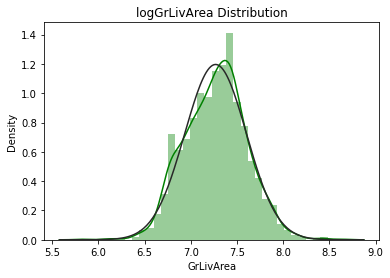

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


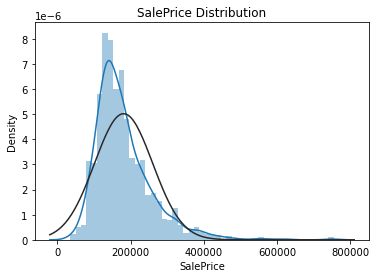

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


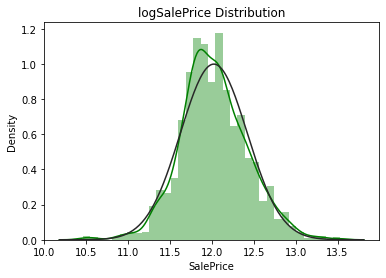

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


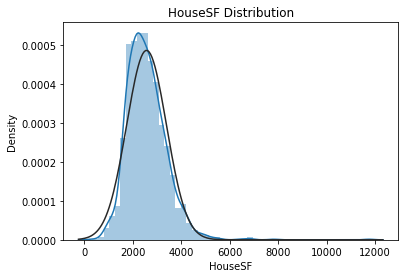

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


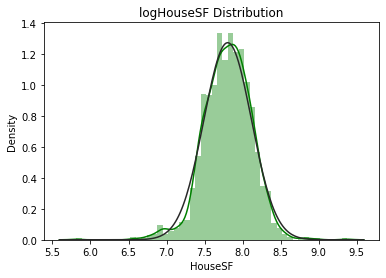

In [7]:
# transform where the log creates a more normal distribution
def norm_trans_features(trans_df):
    logged_cols = ['1stFlrSF', 'SalePrice', 'HouseSF']
    for col in logged_cols:
        trans_df['log' + col] = np.log(trans_df[col])
        trans_df.drop(col, axis=1, inplace=True)
        
    return trans_df


# check if transforming makes the var more normal

num_col_df = trans_df.copy().select_dtypes(include=['int', 'float'])

for col in num_col_df.columns:
    if (trans_df[col].nunique() > 20) and (sum(trans_df[col].isin([0])) == 0):
        p = sns.distplot(trans_df[col] , fit=norm)
        p.set_title(col + ' Distribution')
        plt.show()

        p = sns.distplot(np.log(trans_df[col]) , fit=norm, color='green')
        p.set_title('log' + col + ' Distribution')
        plt.show()


trans_df = norm_trans_features(trans_df)



### Check categorical features with a large number of distinct values

Are these necessary? Can they be clustered for fewer categories?
* MSSubClass is based on year and house type - features we have separately in our data. Drop this.
* Exterior1st and 2nd don't seem to correlate with sale price much. Drop these.
* Neighborhood seems to correlate with sale price. Keep this.


Large number of categories:


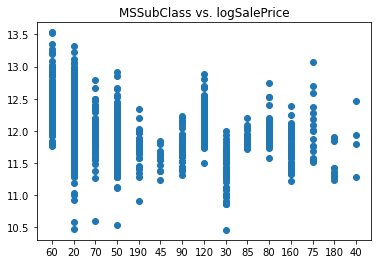

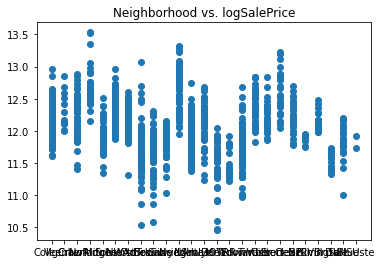

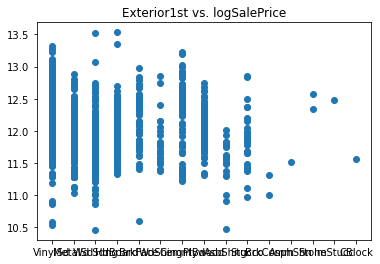

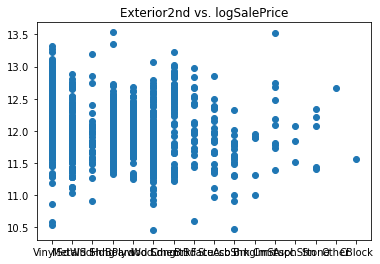

In [8]:
feat_df = trans_df.copy()

print('\nLarge number of categories:')
str_col_df = feat_df.copy().select_dtypes(include=['object'])
for col in str_col_df.columns:
    if str_col_df[col].nunique() >= 10:
        plt.scatter(feat_df[col], feat_df['logSalePrice'])
        plt.title(col + ' vs. logSalePrice')
        plt.show()
        
feat_df.drop(['MSSubClass', 'Exterior1st', 'Exterior2nd'], axis=1, inplace=True)
        
        

### Low variance categorical variables

Remove low-variance categorical variables - those where at least 96% of the values are the same. These won't tell us much about the house, and the 5% are outliers and should probably be removed anyway.


In [9]:
print('\n\033[1mDropped due to low variance:\033[0m')
str_col_df = feat_df.copy().select_dtypes(include=['object'])
for col in str_col_df.columns:
    if str_col_df[col].value_counts().max()/str_col_df[col].value_counts().sum() >= 0.96:
        print('\n' + col)
        print(feat_df[col].value_counts())
        feat_df.drop(col, axis=1, inplace=True)


Dropped due to low variance:

Condition2
Norm      1445
Feedr        6
PosN         2
Artery       2
RRNn         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

RoofMatl
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Roll          1
Membran       1
Metal         1
ClyTile       1
Name: RoofMatl, dtype: int64

Heating
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64


### Dummy up the remaining categorical variable

* First, plot against sale price. None look definitely useless.
* Next, create dummy binary columns for each category.
* Finally, remove those with low variance. This time, include the numerical values.
    * We could use a variance calculation for these, but this way is more conservative.

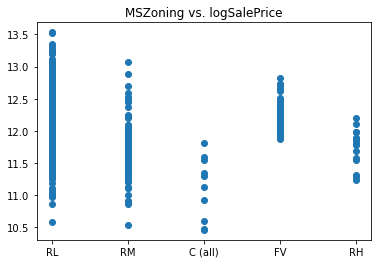

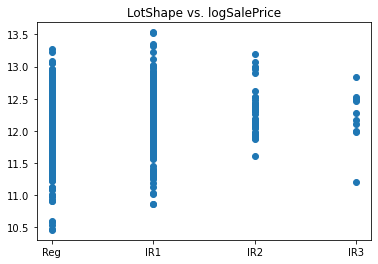

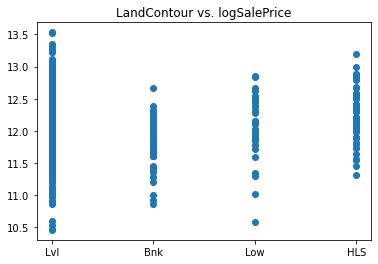

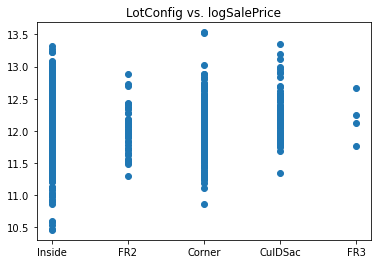

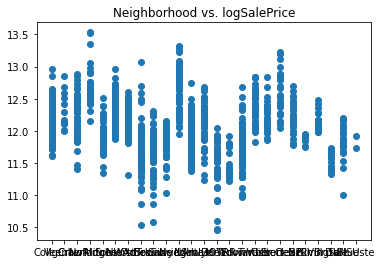

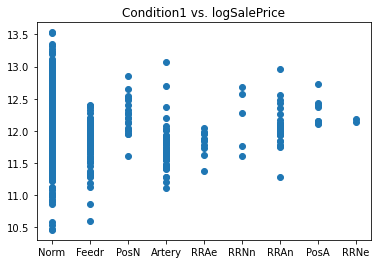

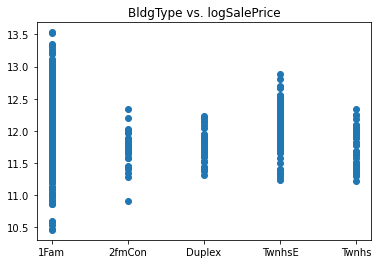

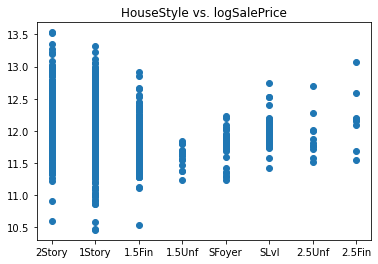

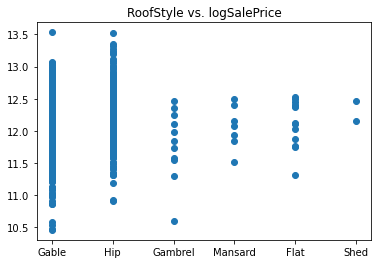

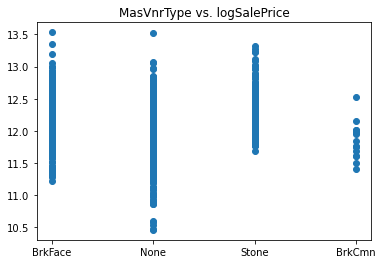

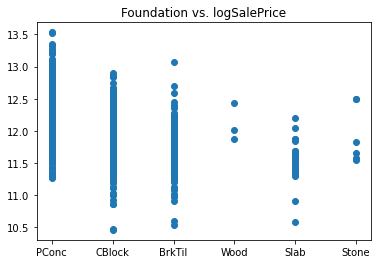

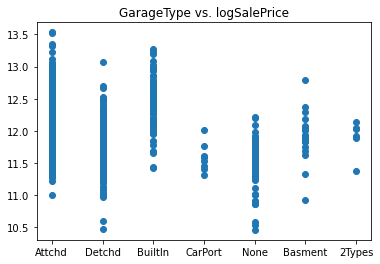

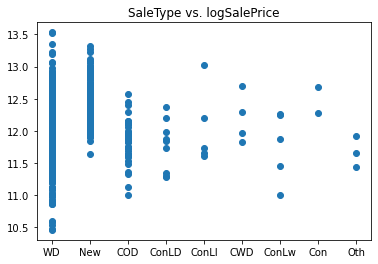

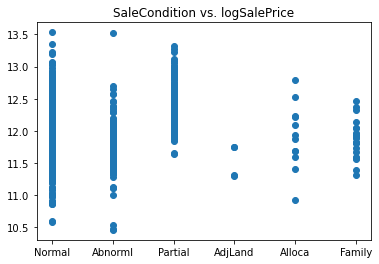


Dropped due to low variance:

Street
1    1454
0       6
Name: Street, dtype: int64

Utilities
4    1459
2       1
Name: Utilities, dtype: int64

LowQualFinSF
0      1434
80        3
360       2
392       1
528       1
515       1
514       1
513       1
481       1
479       1
473       1
420       1
397       1
390       1
53        1
384       1
371       1
234       1
232       1
205       1
156       1
144       1
120       1
572       1
Name: LowQualFinSF, dtype: int64

3SsnPorch
0      1436
168       3
216       2
144       2
180       2
407       1
320       1
304       1
290       1
245       1
238       1
182       1
196       1
23        1
162       1
153       1
140       1
130       1
96        1
508       1
Name: 3SsnPorch, dtype: int64

BsmtExists
1.0    1423
0.0      37
Name: BsmtExists, dtype: int64

PoolExists
0.0    1453
1.0       7
Name: PoolExists, dtype: int64

ShedExists
0.0    1411
1.0      49
Name: ShedExists, dtype: int64

MSZoning_C (all)
0    1450
1      10

In [10]:
# function to dummy up categorical variables
def str_to_cat(feat_df):
    
    # convert category columns to type category
    cat_col_list = []
    str_col_df = feat_df.copy().select_dtypes(include=['object'])
    for col in str_col_df.columns:
        feat_df[col] = feat_df[col].astype('category')
        cat_col_list.append(col)

    # create dummy columns and add back to the df
    feat_df = pd.concat([feat_df, pd.get_dummies(feat_df.select_dtypes(include=['category']))], axis=1).drop(cat_col_list,axis=1)

    return feat_df


# plot the categorical variables against price
str_col_df = feat_df.copy().select_dtypes(include=['object'])
for col in str_col_df.columns:
    plt.scatter(feat_df[col], feat_df['logSalePrice'])
    plt.title(col + ' vs. logSalePrice')
    plt.show()
    

# dummy up categorical variables
feat_df = str_to_cat(feat_df)


# exclude columns with low variance again - this time including the dummies
print('\n\033[1mDropped due to low variance:\033[0m')
for col in feat_df.columns:
    if feat_df[col].value_counts().max()/feat_df[col].value_counts().sum() >= 0.96:
        print('\n' + col)
        print(feat_df[col].value_counts())
        feat_df.drop(col, axis=1, inplace=True)
    

### Collinearity

Check collinearity on columns where collinearity is expected.


['2ndFlrExists', '2ndFlrSF', 'AgeAtSale', 'AlleyExists', 'BedroomAbvGr', 'BldgType_1Fam', 'BldgType_TwnhsE', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1_Feedr', 'Condition1_Norm', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'FenceExists', 'FireplaceExists', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'FullBath', 'Functional', 'GarageAge', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType_Attchd', 'GarageType_BuiltIn', 'GarageType_Detchd', 'GarageType_None', 'GrLivArea', 'HalfBath', 'HeatingQC', 'HouseStyle_1.5Fin', 'HouseStyle_1Story', 'HouseStyle_2Story', 'HouseStyle_SLvl', 'KitchenAbvGr', 'KitchenQual', 'LandContour_Bnk', 'LandContour_Lvl', 'LandSlope', 'LotArea', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_Inside', 'LotFrontage', 'LotShape_IR1', 'LotShape_Reg', 'MSZoning_FV', 'MSZoning_

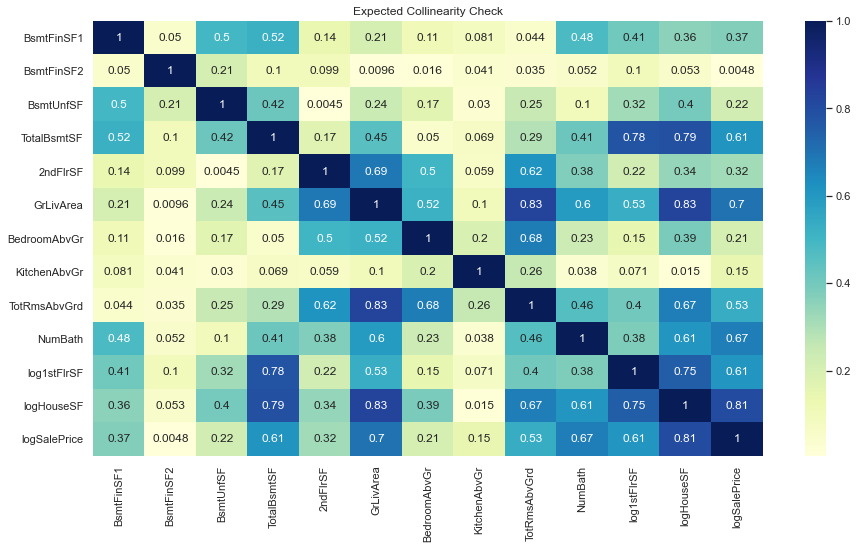

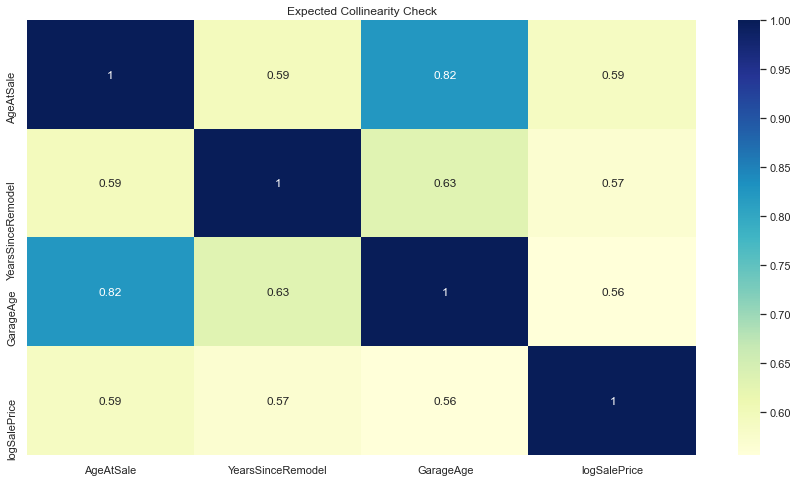

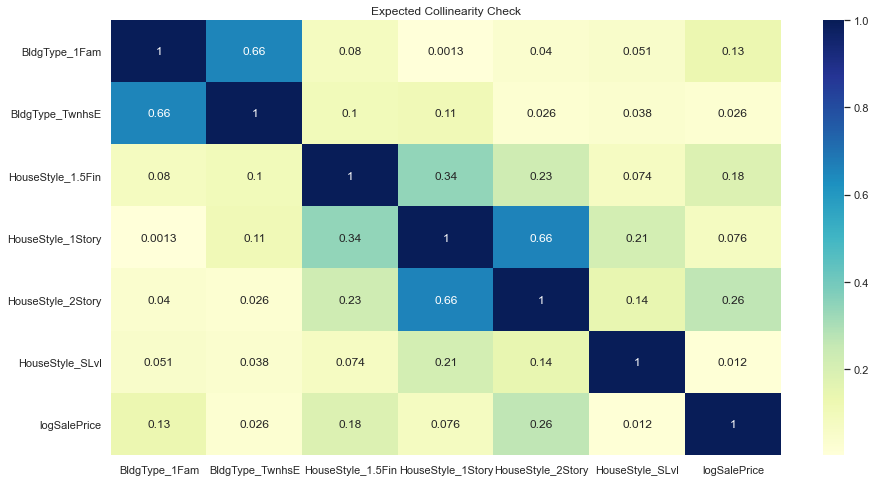

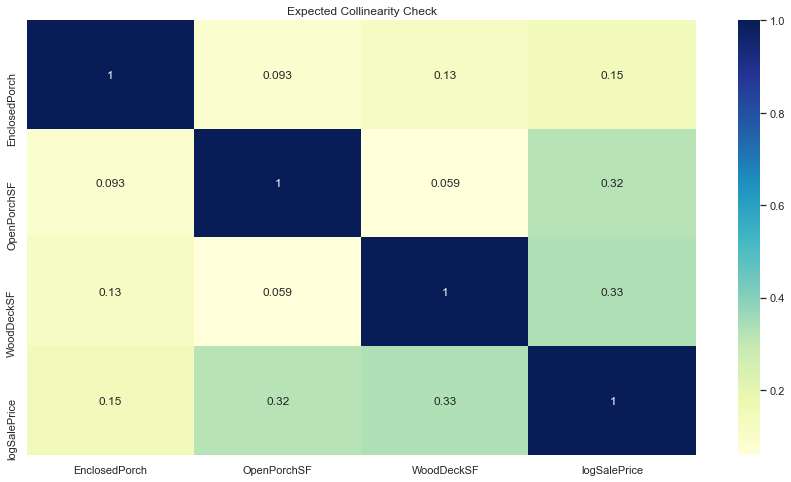

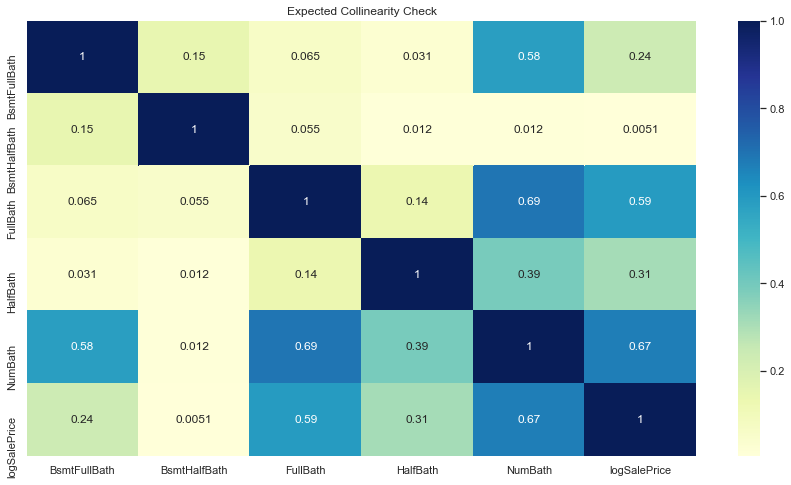

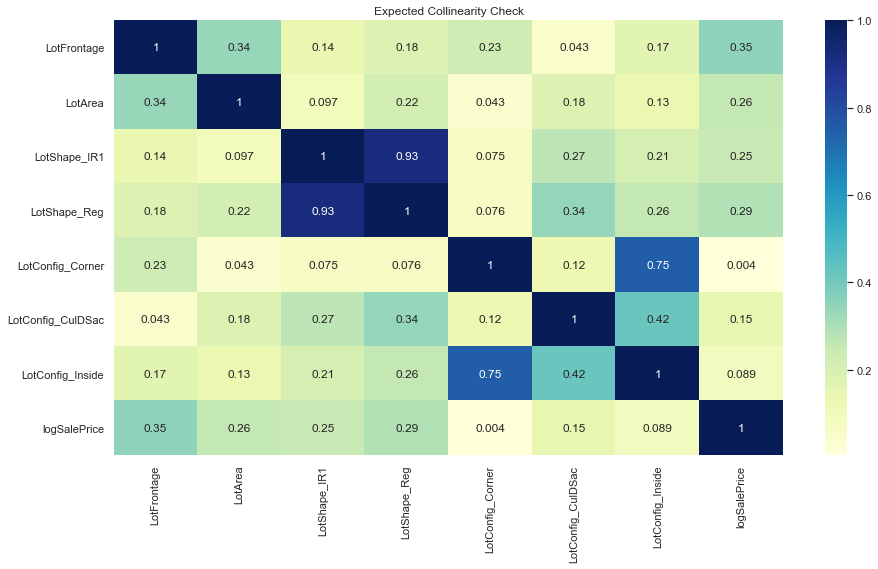

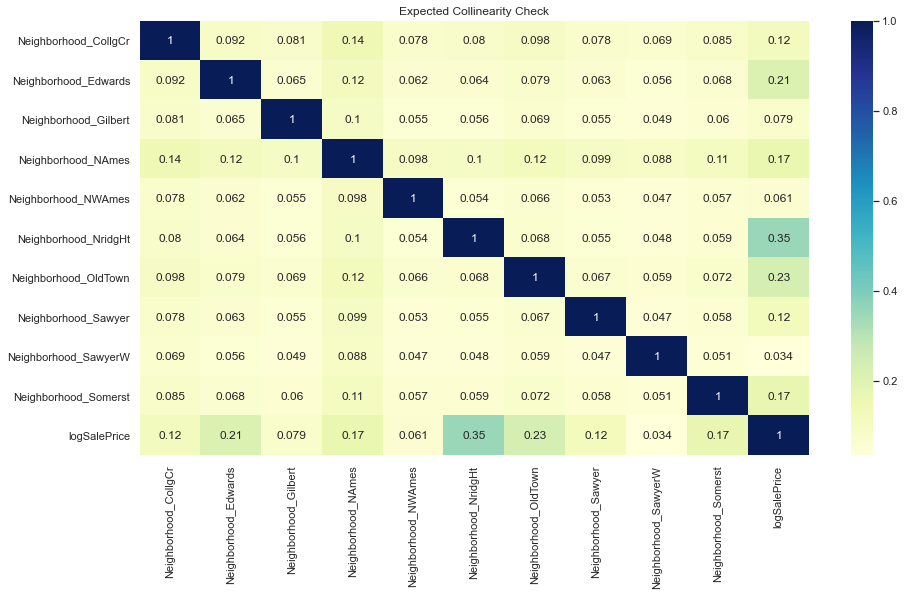

In [12]:
print(sorted(feat_df.columns))

size_cols = [col for col in feat_df.columns if ('SF' in col and col not in ['OpenPorchSF', 'WoodDeckSF']) or ('Gr' in col) or ('NumBath' in col)]
age_cols = [col for col in feat_df.columns if ('Age' in col) or ('Years' in col)]
bldg_type_cols = [col for col in feat_df.columns if ('BldgType' in col) or ('HouseStyle' in col)]
outdoor_cols = ['EnclosedPorch', 'OpenPorchSF', 'WoodDeckSF']
bath_cols = [col for col in feat_df.columns if 'Bath' in col]
lot_cols = [col for col in feat_df.columns if 'Lot' in col]
neighborhood_cols = [col for col in feat_df.columns if 'Neighborhood' in col]

sns.set(rc = {'figure.figsize':(15,8)})
for sus_cols in [size_cols, age_cols, bldg_type_cols, outdoor_cols, bath_cols, lot_cols, neighborhood_cols]:
    sus_cols.append('logSalePrice')
    suspect_collin_df = feat_df[sus_cols]
    sus_corrmat = suspect_collin_df.corr().abs()
    
    p = sns.heatmap(sus_corrmat, cmap='YlGnBu', annot=True)
    p.set_title('Expected Collinearity Check')
    plt.show()
    


Remove columns due to collinearity:
* Size: 
    * Log house SF highly correlated with gr living area, total basement and log 1st fl SF, total rooms above ground, and number of baths. Keep house SF and number of baths (as a stand in for other bath variables), remove others. 
    * Total basement SF is correlated with finshed basement SF1 and unfinished basement SF. Keep total basement SF.
* Age: All the age related variables are correlated. Keep only age at sale.
* Building type
    * Townhouse and Single Family are the only remaining building types and are correlated. Drop townhouse.
    * 2-story and 1-story are correlated. Drop 1-story.
* Baths: Number of baths is correlated with other number of bath variables. Keep number of baths.
* Lot:
    * Lot shape regular is correlated with lot shape irregular
    * Lot configurations are correlated. Keep lot configuration cul-de-sac.

In [13]:
to_drop = ['GrLivArea', 'TotalBsmtSF', 'log1stFlrSF', 'TotRmsAbvGrd', 'BsmtFinSF1', 'BsmtUnfSF', 
           'YearsSinceRemodel', 'GarageAge', 'BldgType_TwnhsE', 'HouseStyle_1Story',
           'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'LotShape_IR1', 
           'LotConfig_Corner', 'LotConfig_Inside']
feat_df.drop(to_drop, axis=1, inplace=True)





Check for collinearity of 0.8 or more. Keep the variable in the pair that is more strongly correlated with the target variable on average.


In [14]:
# handle all cols collinearity
corrmat = feat_df.corr()
abs_corrmat = feat_df.corr().abs()
upper = abs_corrmat.where(np.triu(np.ones(abs_corrmat.shape), k=1).astype(bool))

# # plot absolute correlations
# sns.set(rc = {'figure.figsize':(15,8)})
# p = sns.heatmap(abs_corrmat, cmap='YlGnBu')#, annot=True)
# p.set_title('Absolute Correlations')
# plt.show()

# for feature pairs with collinearity > 0.8, keep the one more highly correlated with the target variable
to_drop = []
for col in upper.columns:
    if col not in ['logSalePrice']:
        collin_df = upper[upper[col] > 0.8]
        for idx in collin_df.index:
            if idx not in ['logSalePrice']:
                print('{f1} : {f2} ({c})'.format(f1=idx, f2=col, c=round(collin_df.loc[idx, col], 2)))
                if abs_corrmat.loc[idx, 'logSalePrice'] < abs_corrmat.loc[col, 'logSalePrice']:
                    to_drop.append(idx)
                else:
                    to_drop.append(col)

print('\nDropped for collinearity:')
print(to_drop)
feat_df.drop(to_drop, axis=1, inplace=True)

GarageCars : GarageArea (0.88)
GarageQual : GarageCond (0.96)
2ndFlrSF : 2ndFlrExists (0.91)
MSZoning_RL : MSZoning_RM (0.81)
MSZoning_FV : Neighborhood_Somerst (0.86)
2ndFlrSF : HouseStyle_2Story (0.81)
RoofStyle_Gable : RoofStyle_Hip (0.93)
MasVnrType_BrkFace : MasVnrType_None (0.81)
GarageQual : GarageType_None (0.94)
GarageCond : GarageType_None (0.95)
SaleType_New : SaleCondition_Partial (0.99)

Dropped for collinearity:
['GarageArea', 'GarageCond', '2ndFlrExists', 'MSZoning_RL', 'MSZoning_FV', 'HouseStyle_2Story', 'RoofStyle_Gable', 'MasVnrType_BrkFace', 'GarageType_None', 'GarageType_None', 'SaleCondition_Partial']


### Remove outliers

Plot to check for outliers, remove, then replot to see correlation.

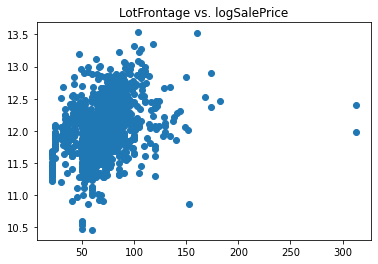

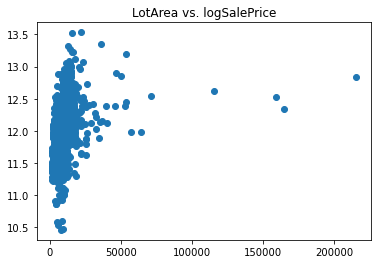

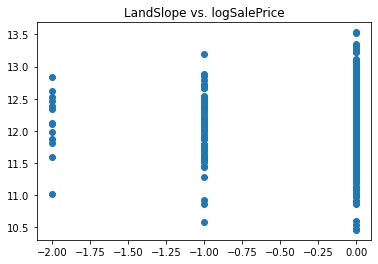

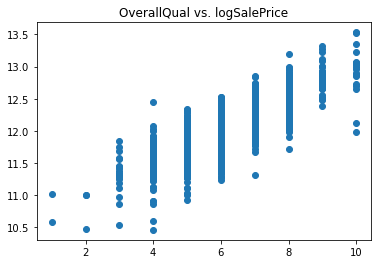

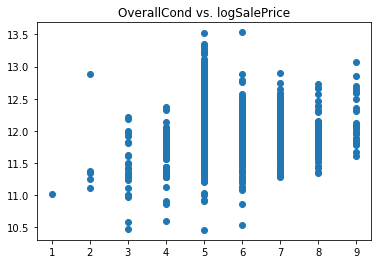

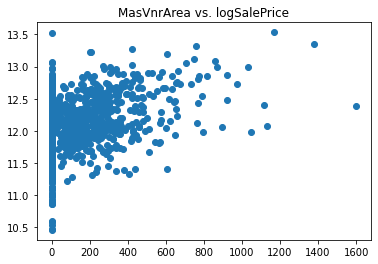

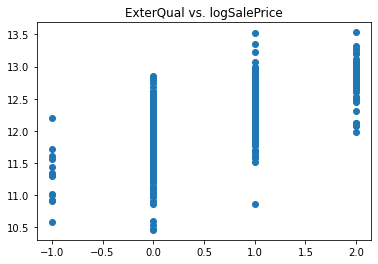

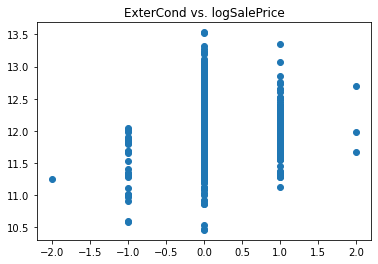

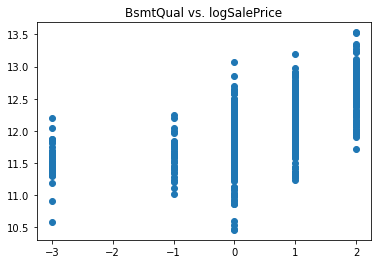

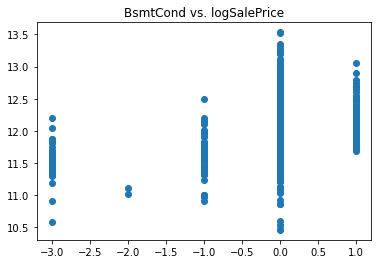

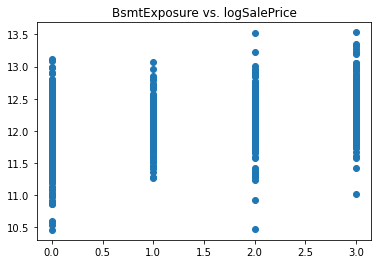

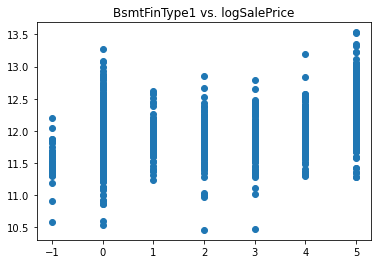

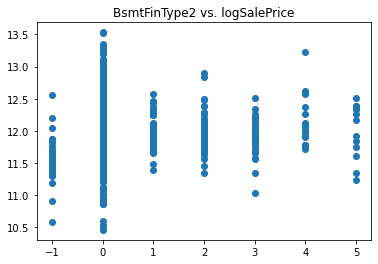

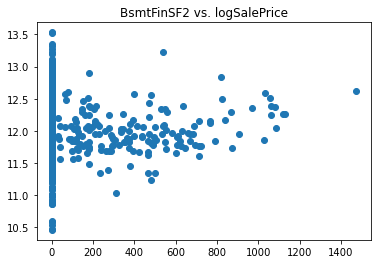

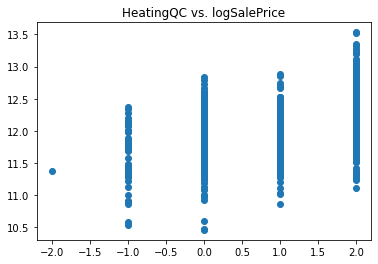

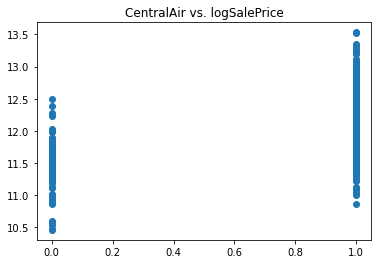

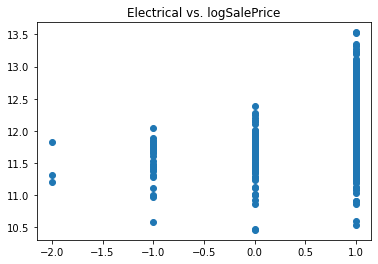

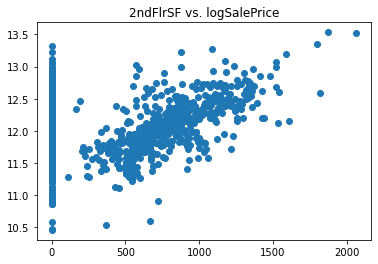

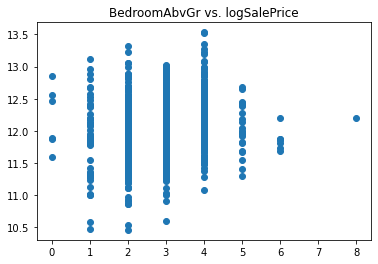

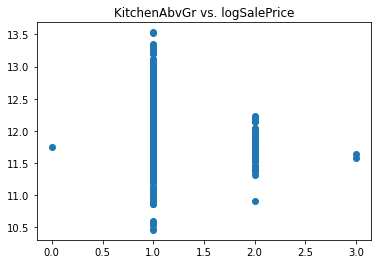

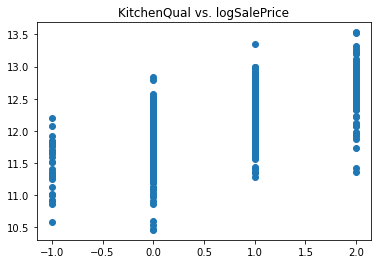

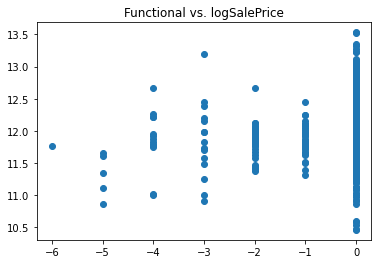

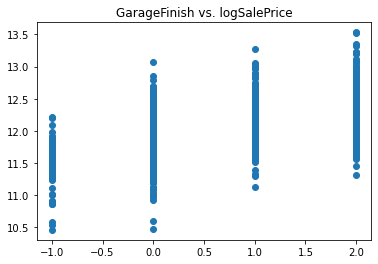

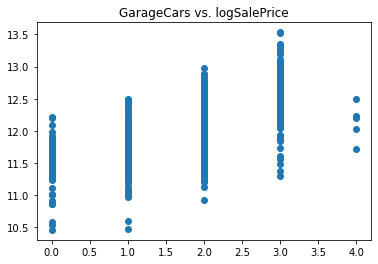

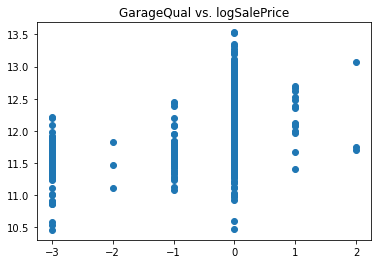

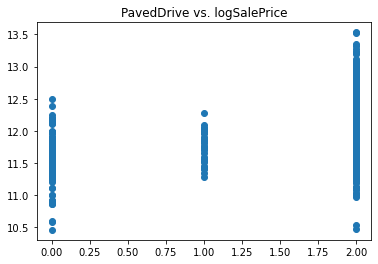

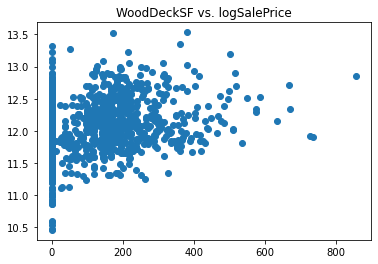

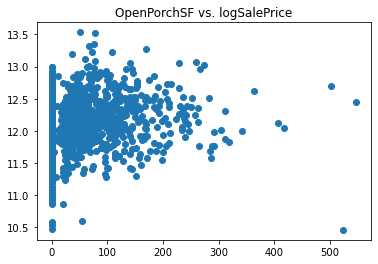

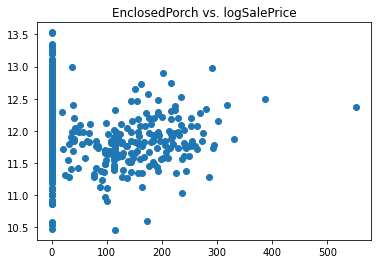

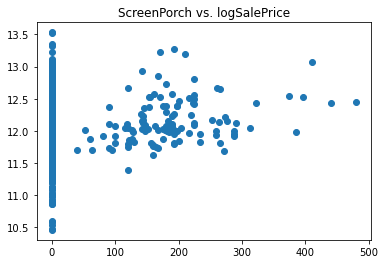

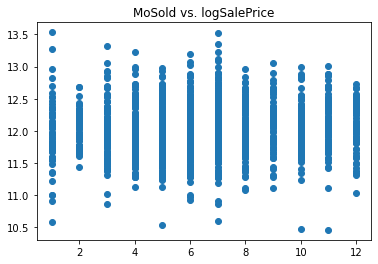

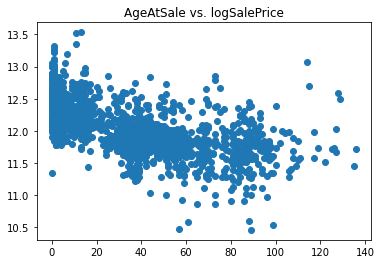

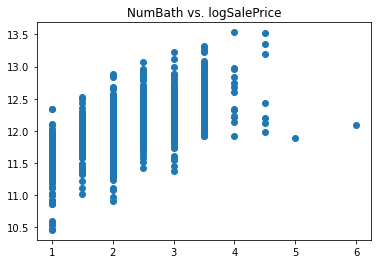

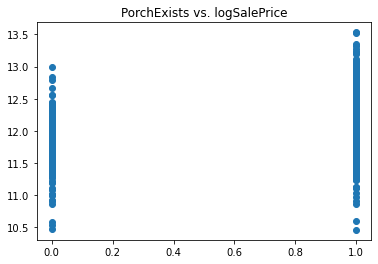

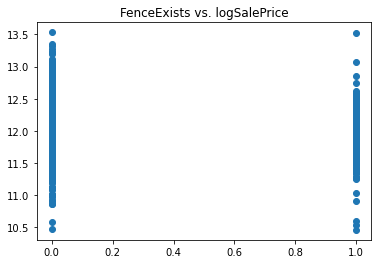

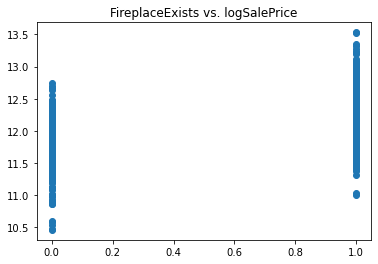

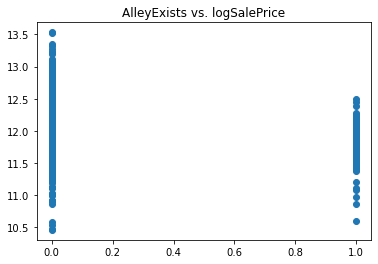

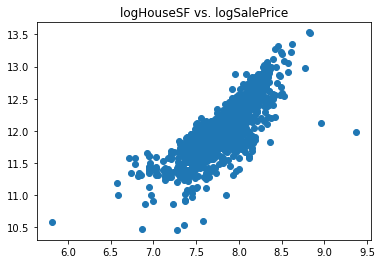

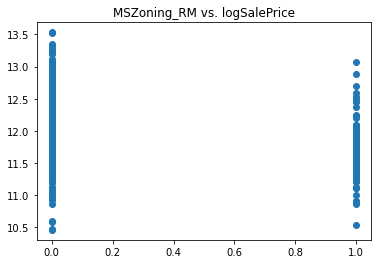

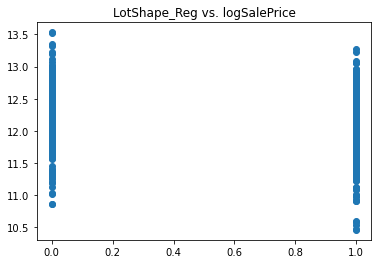

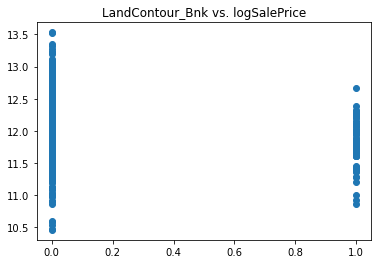

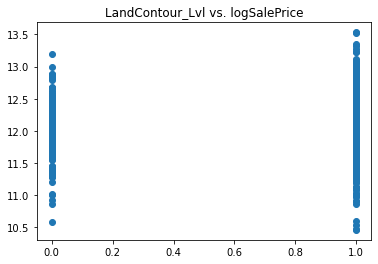

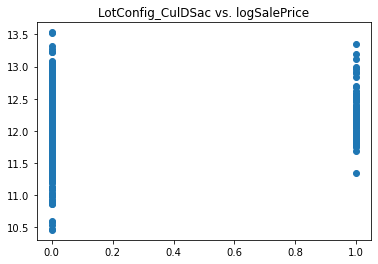

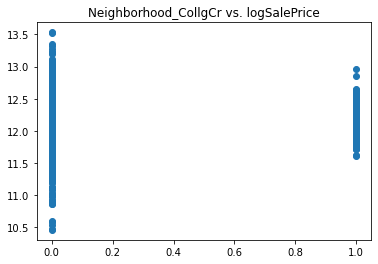

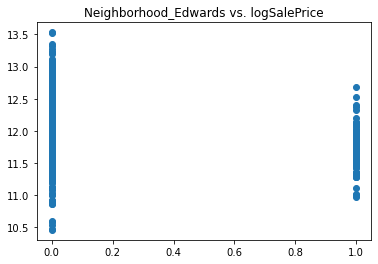

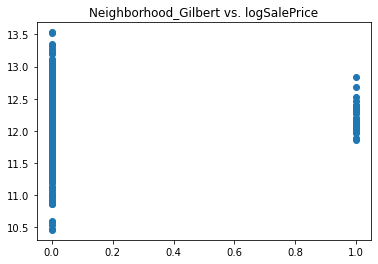

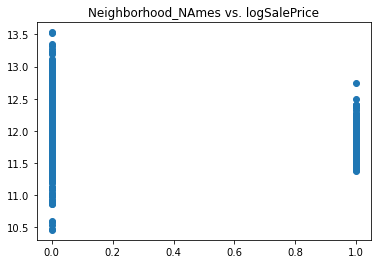

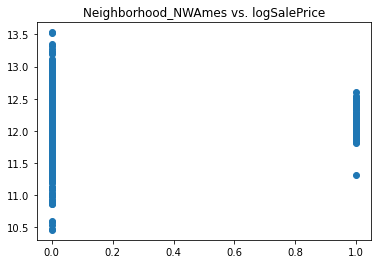

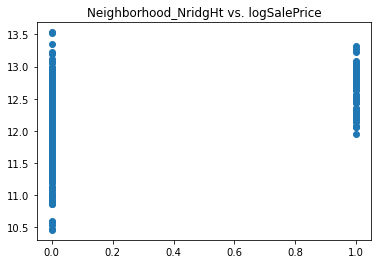

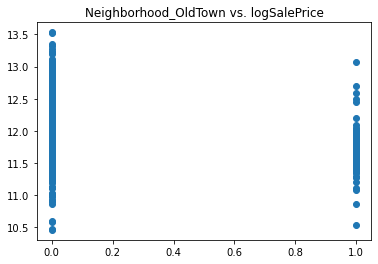

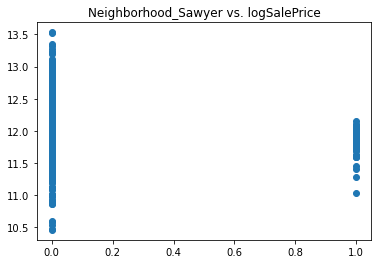

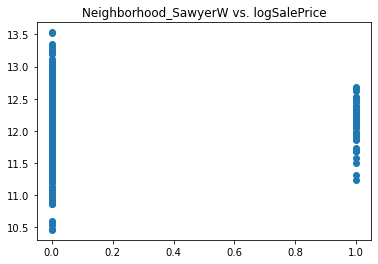

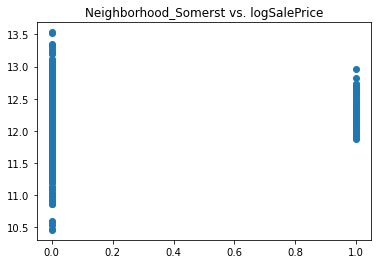

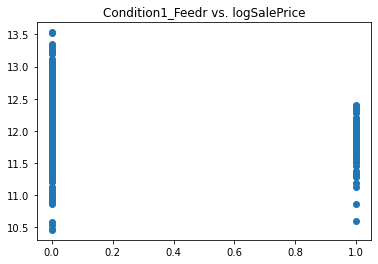

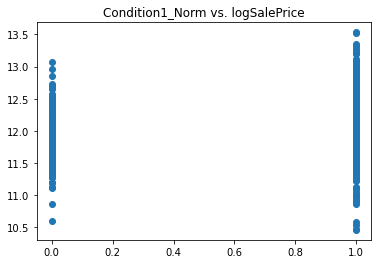

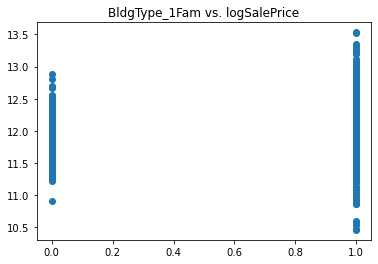

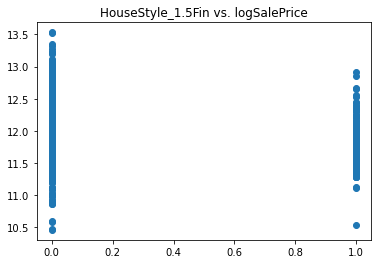

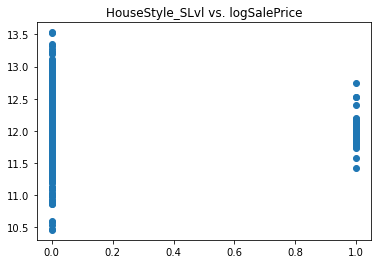

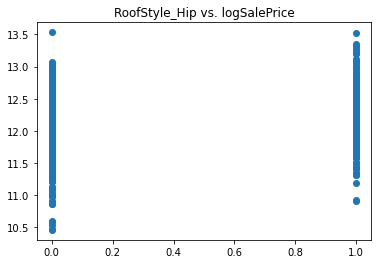

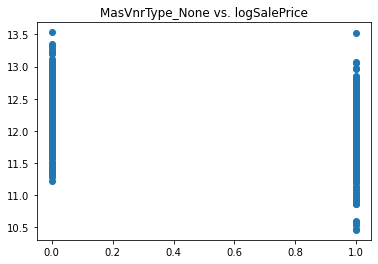

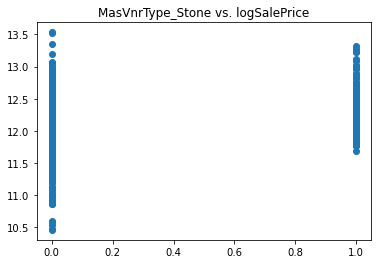

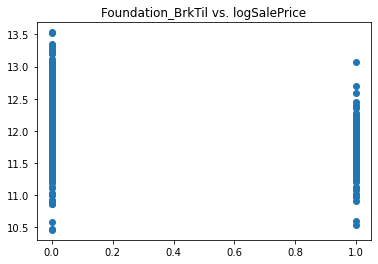

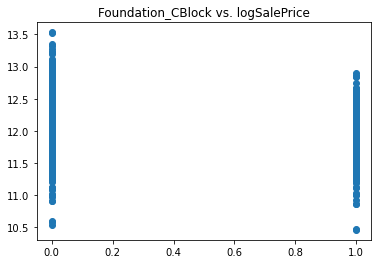

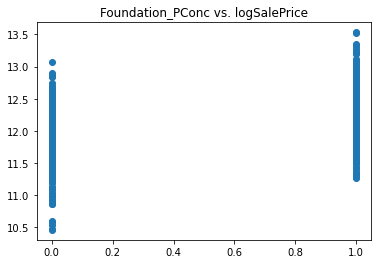

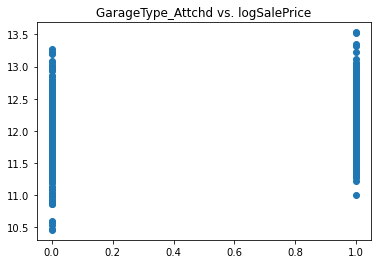

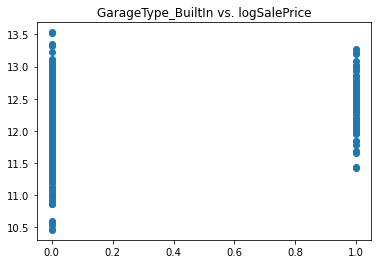

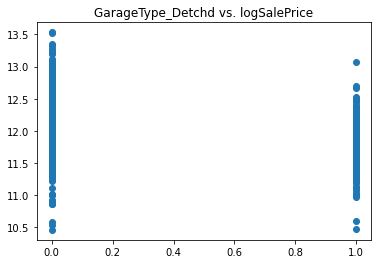

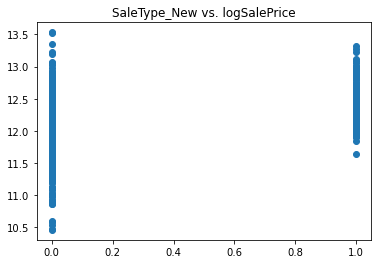

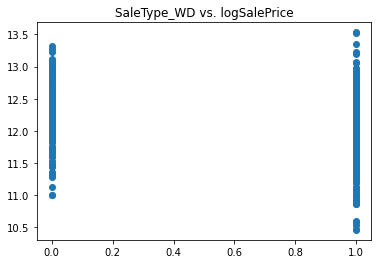

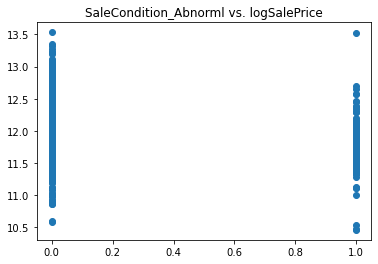

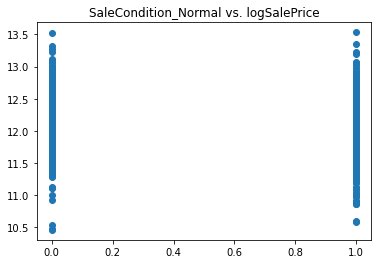

In [15]:
# plot each feature against the log sale price
with warnings.catch_warnings(record=True):
    mpl.rcParams.update(inline_rc)
for col in feat_df.columns:
    if col not in ['logSalePrice']:
        plt.scatter(feat_df[col], feat_df['logSalePrice'])
        plt.title(col + ' vs. logSalePrice')
        plt.show()
            

DF length before removing outliers: 1460
DF length after removing outliers: 1452


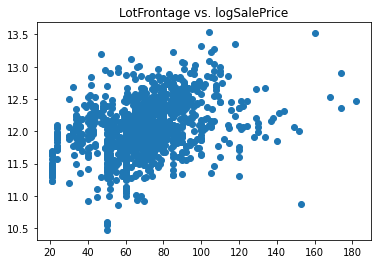

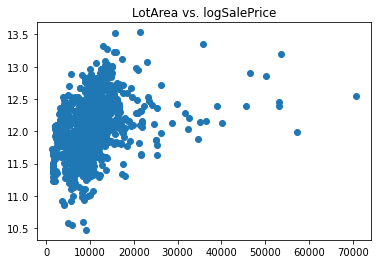

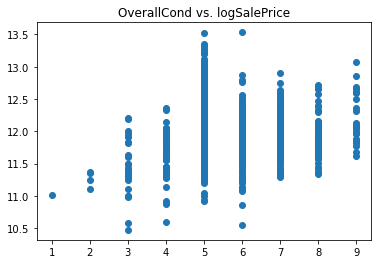

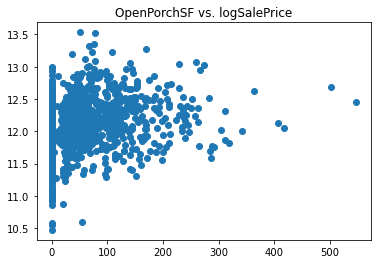

In [16]:
print('DF length before removing outliers: ' + str(len(feat_df)))
feat_w_outliers = ['LotFrontage', 'LotArea', 'OverallCond', 'OpenPorchSF']

feat_df = feat_df[feat_df['LotFrontage'] < 250]
feat_df = feat_df[feat_df['LotArea'] < 100000]
feat_df = feat_df[~((feat_df['OverallCond'] == 2.0) & (feat_df['logSalePrice'] > 12.5))]
feat_df = feat_df[~((feat_df['OpenPorchSF'] > 500) & (feat_df['logSalePrice'] < 11.0))]

print('DF length after removing outliers: ' + str(len(feat_df)))

for col in feat_w_outliers:
    plt.scatter(feat_df[col], feat_df['logSalePrice'])
    plt.title(col + ' vs. logSalePrice')
    plt.show()


We removed 8 records by removing the outliers.

### High correlation with the target variable

Get the correlation coefficients for the target variables and the features on different subsets of data. Keep only those that acheived 0.3 or higher at least once.


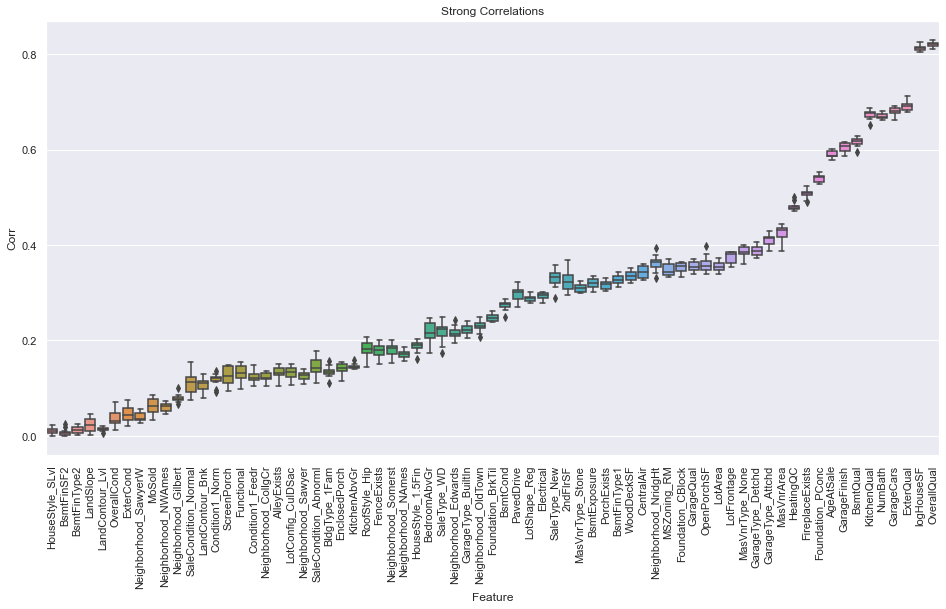

In [17]:
# get the variables most correlated with the target variable
target_var = 'logSalePrice'

# run 10 times on different subsets of the data to find the most reliably correlated
corr_df_list = []
for i in range(1, 11):

    # split into train and test data
    feature_df = feat_df.drop(target_var, axis=1) 
    target_df = feat_df[target_var]
    feat_train, feat_test, target_train, target_test = train_test_split(feature_df, target_df, test_size=0.25, random_state=i)
    train_df = feat_train.merge(target_train.to_frame(), left_index=True, right_index=True)

    # keep only the features that are highly correlated with the target variable
    sorted_corrs = train_df.corr()[target_var].abs().sort_values()
    sorted_corrs = sorted_corrs[sorted_corrs.index != target_var].reset_index()
    corr_df_list.append(sorted_corrs)
    
corr_df = pd.concat(corr_df_list)
corr_df.rename(columns={'index': 'Feature', target_var: 'Corr'}, inplace=True)

# get the average correlation with the target variable
corr_groupby = corr_df.groupby('Feature').agg(['mean', 'max', 'min'])
corr_groupby.columns = [' '.join(col).strip() for col in corr_groupby.columns.values]
corr_groupby.reset_index(inplace=True)
corr_df = pd.merge(corr_df, corr_groupby, how='left', on='Feature')

# plot correlations of the stronger (or all) features
strong_corr_df = corr_df[corr_df['Corr max'] > 0.0].sort_values('Corr')
strong_corr_df = strong_corr_df[strong_corr_df['Feature'] != 'logSalePrice']

sns.set(rc = {'figure.figsize':(16, 8)})
ax = sns.boxplot(x='Feature', y='Corr', data=strong_corr_df)
ax.set_title('Strong Correlations')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

# remove the weakly correlated features (or none)
strong_corr_df = corr_df[corr_df['Corr min'] > 0.0]
feat_cols = list(strong_corr_df['Feature'].drop_duplicates())
feat_cols.append(target_var)
feat_df = feat_df[feat_cols]

    

## Linear regression model

Plain vanilla linear regression using 10-fold cross validation. Test on different columns, starting with the most highly correlated to the target variable, to see which combination yields the best results.

In [31]:
from sklearn.linear_model import LinearRegression

def run_lr_model(df, feat_cols, target_col):
    
    # set up the folds
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # instantiate the model
    mod = LinearRegression()

    # fit the model and perform cross validation
    cv_results = cross_validate(mod, df[feat_cols], df[target_col], scoring='neg_mean_squared_error', cv=kf, return_estimator=True)

    # get the rmse
    avg_score = abs(np.mean(cv_results['test_score'])) ** 0.5
    
    # get the coefficients from the model
    coef_list = []
    for model in cv_results['estimator']:
        coefficients = pd.concat([pd.DataFrame(feat_cols),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
        coef_list.append(coefficients)
    coef_df = pd.concat(coef_list)
    coef_df.columns = ['Feature', 'Coef']
    
    return avg_score, coef_df
    

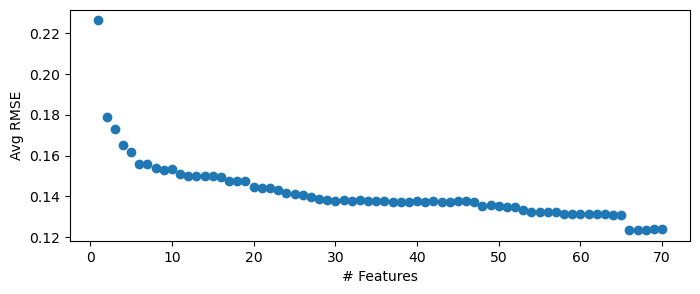

In [33]:
# get the rmse for different col combos

target_col = 'logSalePrice'
poss_feat_cols = [col for col in strong_corr_df.sort_values(by='Corr mean', ascending=False)['Feature'].unique() if col != 'SalePrice' and col in feat_df.columns]

score_dict = {}
for i in range(1, len(poss_feat_cols)):
    avg_score, coef_df = run_lr_model(feat_df, poss_feat_cols[:i], target_col)
    score_dict[i] = avg_score

plt.rcdefaults()
plt.figure(figsize=(8, 3))
plt.scatter(score_dict.keys(), score_dict.values())
plt.xlabel('# Features')
plt.ylabel('Avg RMSE')
plt.show()



66 features seems to yield the best results. Run the linear regression model for that.

In [35]:
target_col = 'logSalePrice'
poss_feat_cols = [col for col in strong_corr_df.sort_values(by='Corr mean', ascending=False)['Feature'].unique() if col != 'SalePrice' and col in feat_df.columns]

avg_score, coef_df = run_lr_model(feat_df, poss_feat_cols[:66], target_col)

print('RMSE: ' + str(avg_score))



RMSE: 0.12340242809530683


**Feature importance**

How does the model weight each feature? In other words, how important is each feature? Can we get rid of the less important ones for a more robust model?


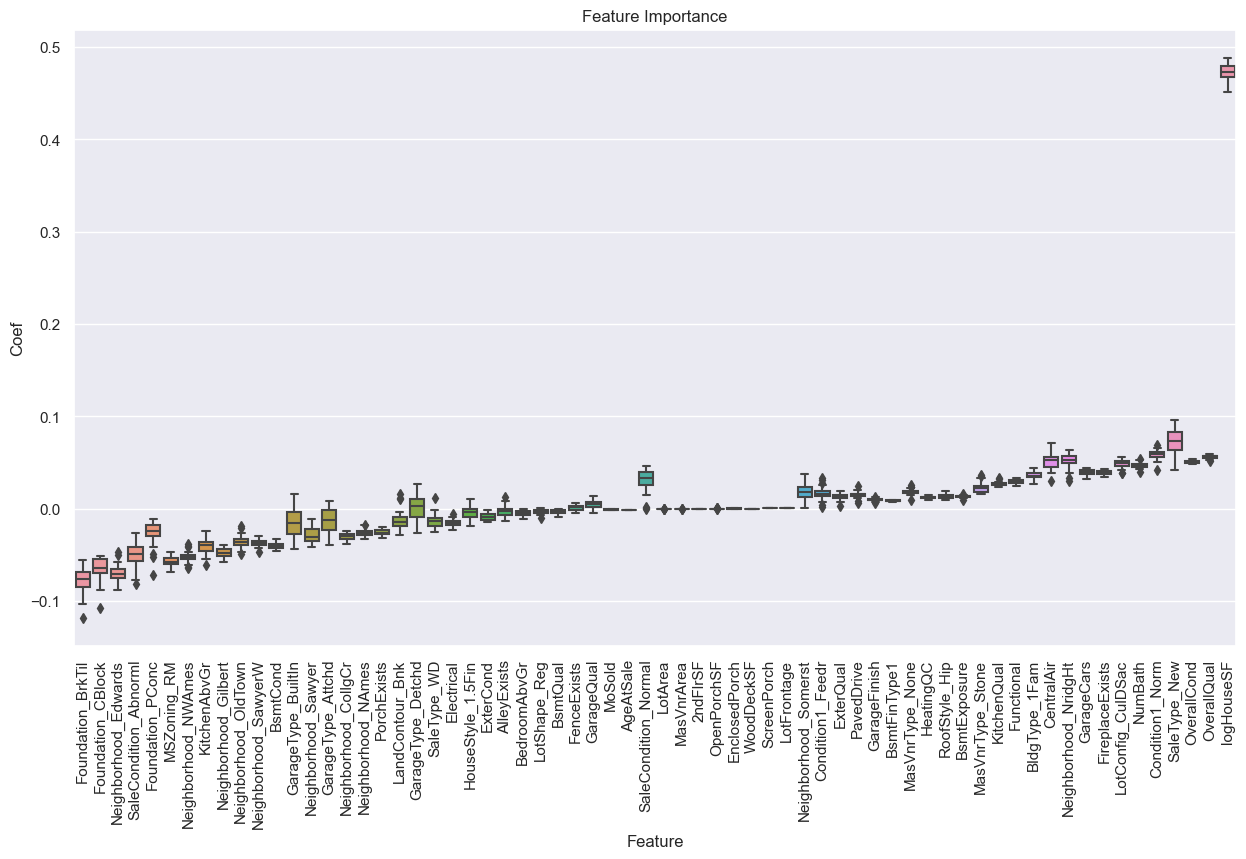

Features to drop
['2ndFlrSF', 'AgeAtSale', 'AlleyExists', 'BedroomAbvGr', 'BldgType_1Fam', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'CentralAir', 'Condition1_Feedr', 'Condition1_Norm', 'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'FenceExists', 'FireplaceExists', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Functional', 'GarageCars', 'GarageFinish', 'GarageQual', 'GarageType_Attchd', 'GarageType_BuiltIn', 'GarageType_Detchd', 'HeatingQC', 'HouseStyle_1.5Fin', 'KitchenAbvGr', 'KitchenQual', 'LandContour_Bnk', 'LotArea', 'LotConfig_CulDSac', 'LotFrontage', 'LotShape_Reg', 'MSZoning_RM', 'MasVnrArea', 'MasVnrType_None', 'MasVnrType_Stone', 'MoSold', 'Neighborhood_CollgCr', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'NumBath', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PavedDr

In [37]:
# plot coefficients
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.boxplot(x='Feature', y='Coef', data=coef_df.sort_values(by='Coef'))
ax.set_title('Feature Importance')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

coef_groupby = coef_df.groupby('Feature').agg(['mean', 'max', 'min'])
coef_groupby.columns = [' '.join(col).strip() for col in coef_groupby.columns.values]
coef_groupby.reset_index(inplace=True)

# drop features that have little importance on the outcome and rerun the model
to_drop = list(coef_groupby[(coef_groupby['Coef min'] >= -100) & (coef_groupby['Coef max'] <= 100)]['Feature'])
new_poss_feat_cols = [col for col in poss_feat_cols if col not in to_drop]
print('Features to drop')
print(to_drop)

rmse, coef = run_lr_model(feat_df, new_poss_feat_cols, target_col)
print('RMSE' + str(rmse))

    

This increases the RMSE. Let's not drop those.

## Elastic Net model

Use the elastic net model to penalize large coefficients.

In [39]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# define model
mod = ElasticNet()

# set up the folds
kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid - try different alphas
grid = dict()
grid['l1_ratio'] = np.arange(0, 1, 0.2)

# define search
search = GridSearchCV(mod, grid, scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1)

# perform the search and get the best results from the grid
results = search.fit(feat_df[poss_feat_cols[:66]], feat_df[target_var])
best_rmse = abs(results.best_score_) ** 0.5
print('Best RMSE: ' + str(best_rmse))
print('Using ratio: ' + str(results.best_params_))



Best RMSE: 0.3421269810674258
Using ratio: {'l1_ratio': 0.0}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.22124787104876, tolerance: 0.02281021314865646
  model = cd_fast.enet_coordinate_descent(


Best alpha to use is 0, meaning that we only use L2, meaning that this is just Lasso regression. But this increases our RMSE from vanilla linear regression, so let's not use this.

## Random Forest model

Use random forest model, trying different hyperparameters.

In [44]:
from sklearn.ensemble import RandomForestRegressor

# define the model
mod = RandomForestRegressor(n_estimators=100)

# set up the folds
kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = dict()
# features to consider at split
grid['max_features'] = ['auto', 'sqrt', 'log2']
# number of levels
grid['max_depth'] = [4, 5, 6, 7, 8]

# define search
search = GridSearchCV(estimator=mod, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=kf)

# perform the search and get the best results from the grid
results = search.fit(feat_df[poss_feat_cols[:66]], feat_df[target_var])
best_rmse = abs(results.best_score_) ** 0.5
print('Best RMSE: ' + str(best_rmse))
print('Using hyperparameters: ' + str(results.best_params_))



Best RMSE: 0.31102882091699036
Using node sample ratio: {'max_depth': 8, 'max_features': 'sqrt'}


Still not as good as simple linear regression. But possibly more robust?

## Random Forest with XGBoost

XGBoost should train faster and provide a stronger model than simple random forest.

 :(    XGBoost not working since I updated my OS. Need to update python.

In [46]:
from xgboost import XGBRFRegressor

# define the model
mod = XGBRFRegressor(n_estimators=100, subsample=0.9, colsample_bynode=0.15)

# set up the folds
kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = dict()
# features to consider at split
grid['colsample_bynode'] = [0.1, 0.2, 0.33, 0.4, 0.5, 0.66]

# define search
search = GridSearchCV(estimator=mod, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=kf)

# perform the search and get the best results from the grid
results = search.fit(feat_df[poss_feat_cols[:66]], feat_df[target_var])
best_rmse = abs(results.best_score_) ** 0.5
print('Best RMSE: ' + str(best_rmse))
print('Using hyperparameters: ' + str(results.best_params_))



XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['dlopen(/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


## Plot the error

Using the best model we have - simple linear regression - compare the predictions on the test set with the actual values.

RMSE: 0.11772598569509705
                       0         0
0            OverallQual  0.053485
1             logHouseSF  0.482049
2              ExterQual  0.017054
3             GarageCars  0.035090
4            KitchenQual  0.032672
..                   ...       ...
61                MoSold  0.000198
62   Neighborhood_NWAmes -0.024759
63             ExterCond -0.000689
64  Neighborhood_SawyerW -0.036781
65           OverallCond  0.045974

[66 rows x 2 columns]
RMSE as percent of logSalePrice mean
0.009791917905218344


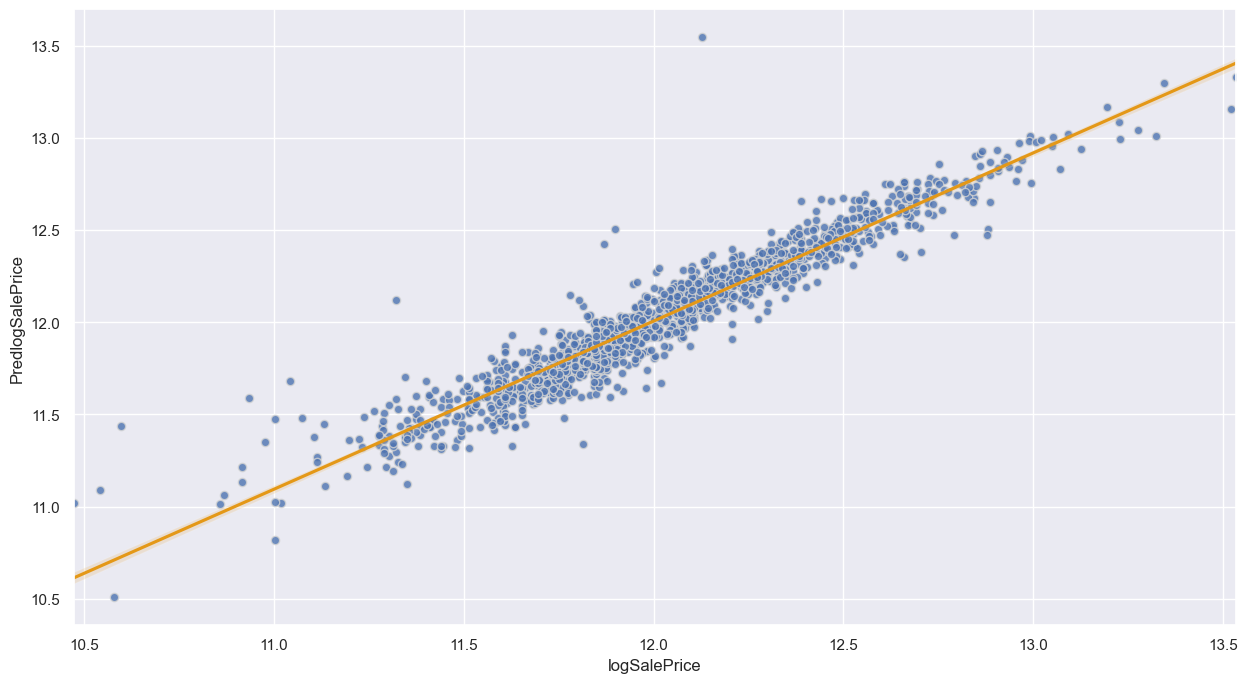

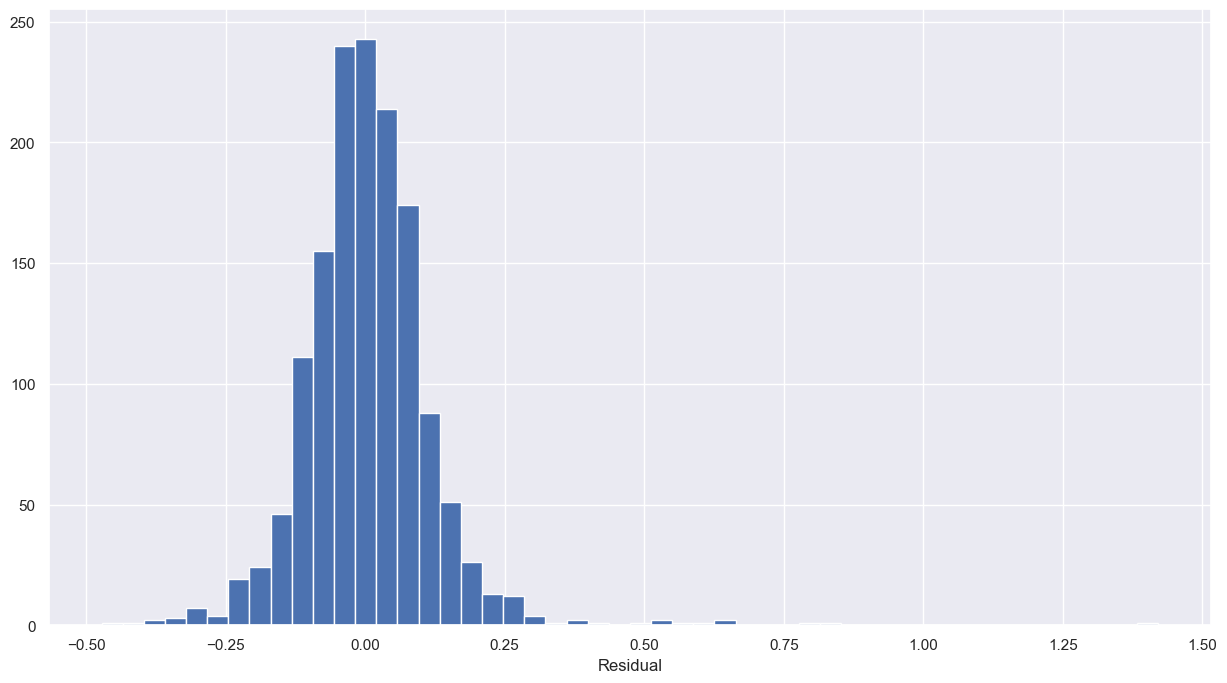

In [54]:
shuffled_df = feat_df.reindex(np.random.RandomState(seed=1).permutation(feat_df.index))
train_df = shuffled_df[:round(0.75 * len(shuffled_df))]
test_df = shuffled_df[~feat_df.index.isin(train_df)]

# fit the model
lr = LinearRegression()
lr.fit(train_df[poss_feat_cols[:66]], train_df[target_col])
coefficients = pd.concat([pd.DataFrame(poss_feat_cols[:66]),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)

test_predictions = lr.predict(test_df[poss_feat_cols[:66]])
mse = mean_squared_error(test_df[target_col], test_predictions)
rmse = mse ** 0.5
print('RMSE: ' + str(rmse))
print(coefficients)

# rmse as percent of target variable mean
print('RMSE as percent of logSalePrice mean')
print(rmse / feat_df['logSalePrice'].mean())

test_df['PredlogSalePrice'] = test_predictions

sns.set_theme()
sns.regplot(x='logSalePrice', y='PredlogSalePrice', data=test_df, scatter_kws={'edgecolors': 'lightgray'}, line_kws={'color': '#e49817'})
plt.show()

plt.hist(test_df['PredlogSalePrice'] - test_df['logSalePrice'], bins=50)
plt.xlabel('Residual')
plt.show()



Not bad, but there are a few clear outliers. We can do better.

## Conclusions

The linear regression model 66 features most correlated with log sale price below yielded an RMSE of 0.12 — 0.09\% of the mean log sale price — under 10-fold cross validation.

## Ideas for future exploration

* Update python to run XGBoost
* Get R^2 and predictions on sale price, which gives better context for errors
* Create a function for testing models
* Group neighborhoods into region?
* Classification models
* More hyperparameter tuning
* Explore other feature selection options

## Generate predictions

In [ ]:
# # generate predictions

# # read in the data and validate format
# final_test_df = pd.read_csv(r'house-prices-advanced-regression-techniques/test.csv')
# print(final_test_df.head())
# print(len(final_test_df))

# # transform the data
# trans_test_df = initial_clean(final_test_df)
# trans_test_df = create_exists_feat(trans_test_df)
# # trans_test_df = handle_missing_values(trans_test_df)
# trans_test_df = map_qual_to_ord(trans_test_df)
# trans_test_df = str_to_cat(trans_test_df)

# # replace null values with mode or mean
# print('\nMissing Values:')
# num_nulls = trans_test_df[best_feat_cols].isnull().sum()
# null_cols = num_nulls[num_nulls > 0]
# for col in null_cols.index:
#     print('\n')
#     print(trans_test_df[col].value_counts())
    
# mode_cols = ['NumBath', 'KitchenQual', 'BsmtQual', 'GarageCars', 'BsmtExposure', 'GarageFinish', 'BsmtFinType1']
# mean_cols = ['TotalBsmtSF', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage']
# for col in mode_cols:
#     trans_test_df[col].fillna(trans_test_df[col].mode()[0], inplace=True)
# for col in mean_cols:
#     trans_test_df[col].fillna(trans_test_df[col].mean(), inplace=True)

# # create the model and train it on all data 
# lr = LinearRegression()
# lr.fit(feat_df[best_feat_cols], feat_df['SalePrice'])
# test_predictions = lr.predict(trans_test_df[best_feat_cols])

# test_pred_df = pd.DataFrame({'Id': trans_test_df['Id'], 'SalePrice': test_predictions})
# print(test_pred_df)
# print(len(test_pred_df))

# # plot predictions
# sns.set(rc = {'figure.figsize':(4,3)})
# sns.histplot(data=feat_df, x='SalePrice', bins=20)
# plt.xlabel('Actual SalePrices')
# plt.show()

# sns.histplot(data=test_pred_df, x='SalePrice', bins=20, color='green')
# plt.xlabel('Predicted SalePrices')
# plt.show()



In [ ]:
# # export

# test_pred_df.to_csv('test_pred_df.csv', index=False)